How to use MacOS GPU MPS
* https://www.youtube.com/watch?app=desktop&v=53PjsHUd46E&t=0s

DINOv2ForImmageClassification
* https://huggingface.co/docs/transformers/en/model_doc/dinov2 

DINOv2 Model Notebook:
* https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Fine_tune_DINOv2_for_image_classification_%5Bminimal%5D.ipynb#scrollTo=OKm-nqi2eJs2

In [25]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch
import torch.optim as optim
from transformers import AutoImageProcessor, Dinov2ForImageClassification

from PIL import Image
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns


### Settings for Model Training

In [26]:
rootPath = "../input/final_split_training_augmented"
trainPath= rootPath + "/train"
evalPath= rootPath + "/eval"
testPath= rootPath + "/test"

checkpoint_dir = os.path.abspath("../models/Dinov2")

model_name = "facebook/dinov2-small-imagenet1k-1-layer"
num_classes = 4
batch_size = 32
learning_rate = 5e-5
epochs = 5
reduction_ratio = 0.2  # Define the reduction ratio for the dataset


# For MacOS MPS
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.backends.mps.is_available()
print("Using device:", "mps" if torch.backends.mps.is_available() else "cpu")

# For CUDA
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

Using device: mps


### Data Loading 
Comment out the reduced dataset creation for full training


In [27]:
transform = transforms.Compose([
    transforms.Resize((518,518)),
    transforms.ToTensor(),
])

def create_reduced_dataset(full_dataset, reduction_ratio):
    total_size = len(full_dataset)
    reduced_size = int(total_size * reduction_ratio)
    indices = list(range(total_size))
    random.shuffle(indices)
    reduced_indices = indices[:reduced_size]
    reduced_dataset = Subset(full_dataset, reduced_indices)
    print(f"Reduced {full_dataset} size: {len(reduced_dataset)}")
    return reduced_dataset

trainDataset = datasets.ImageFolder(root=trainPath, transform=transform)
evalDataset = datasets.ImageFolder(root=evalPath, transform=transform)

# Commenting out the reduced dataset creation for full training or change above reduction ratio to 1.0
trainDataset = create_reduced_dataset(trainDataset, reduction_ratio)
evalDataset = create_reduced_dataset(evalDataset, reduction_ratio)


train_dataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=num_classes)
eval_dataloader = DataLoader(evalDataset, batch_size=batch_size, shuffle=False, num_workers=num_classes)


type(trainDataset)
first_element = trainDataset[0]
print(f"Type of the first element: {type(first_element)}")
image, label = first_element
print(f"Type of the image in the first element: {type(image)}")
print(f"Is the image a PIL Image? {isinstance(image, Image.Image)}")


Reduced Dataset ImageFolder
    Number of datapoints: 8025
    Root location: ../input/final_split_training_augmented/train
    StandardTransform
Transform: Compose(
               Resize(size=(518, 518), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ) size: 1605
Reduced Dataset ImageFolder
    Number of datapoints: 579
    Root location: ../input/final_split_training_augmented/eval
    StandardTransform
Transform: Compose(
               Resize(size=(518, 518), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ) size: 115
Type of the first element: <class 'tuple'>
Type of the image in the first element: <class 'torch.Tensor'>
Is the image a PIL Image? False


In [28]:
# Number of classes in your dataset
num_classes = len(trainDataset.dataset.classes) 
print(num_classes)
print(trainDataset.dataset.classes)


4
['angry', 'happy', 'relaxed', 'sad']


### Check Distribution of Dataset

In [29]:
import os

def checkfolder(root="../input", actualFolder="final_split_training_augmented"):
    folder = os.path.join(root, actualFolder)
    if os.path.exists(folder):
        for sub in os.listdir(folder):
            print("------------")
            print(sub)
            subFolder = os.path.join(folder, sub)
            if os.path.isdir(subFolder):
                total_images_subfolder = 0
                emotion_counts = {}
                for emotion in os.listdir(subFolder):
                    subFolderEmotion = os.path.join(subFolder, emotion)
                    if os.path.isdir(subFolderEmotion):
                        count = len(os.listdir(subFolderEmotion))
                        emotion_counts[emotion] = count
                        total_images_subfolder += count

                if total_images_subfolder > 0:
                    for emotion, count in emotion_counts.items():
                        percentage = (count / total_images_subfolder) * 100
                        print(f"{emotion} : {count} - {percentage:.2f}%")
                else:
                    print(f"No images found in {subFolder}")
            else:
                print(f"{subFolder} is not a directory.")
    else:
        print(f"Folder not found: {folder}")

checkfolder()

------------
test
happy : 148 - 25.87%
sad : 138 - 24.13%
angry : 140 - 24.48%
relaxed : 146 - 25.52%
------------
train
happy : 2079 - 25.91%
sad : 1932 - 24.07%
angry : 1965 - 24.49%
relaxed : 2049 - 25.53%
------------
eval
happy : 150 - 25.91%
sad : 139 - 24.01%
angry : 142 - 24.53%
relaxed : 148 - 25.56%


### Model Training

In [30]:
if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
        
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = Dinov2ForImageClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)
freeze_backbone = True
model.to(device)
model.train()

# Freeze all layers except the classifier
if freeze_backbone:
    for name, param in model.named_parameters():
        if "classifier" not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []
all_true_labels = []
all_predicted_labels = []


for epoch in range(epochs):
    
    # Training loop
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    # batch: In each iteration of this loop, batch will contain one batch of data loaded by your train_dataloader. Since you created the train_dataloader from a torch.utils.data.Dataset (specifically a Subset of ImageFolder), each batch will typically be a list or tuple containing:
    # A tensor of images (the first element, batch[0]). -> PyTorch tensors of shape (batch_size, C, H, W) e.g. (32, 3, 224, 224) for a batch size of 32 and colour images resized to 224x224.
    # A tensor of corresponding labels (the second element, batch[1]).
    for batch in progress_bar:

        inputs = image_processor(images=list(batch[0]), return_tensors="pt", do_rescale=False).to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs['pixel_values'].size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        progress_bar.set_postfix({"loss": total_loss / total_samples, "accuracy": correct_predictions / total_samples})

    epoch_loss = total_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")
    
    # Optionally, checkpoint the model.
    if checkpoint_dir:
        path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
        torch.save(model.state_dict(), path)



    # Evaluation loop
    model.eval()
    eval_loss = 0
    eval_correct_predictions = 0
    eval_total_samples = 0
    current_epoch_true_labels = []
    current_epoch_predicted_labels = []
    with torch.no_grad():
        progress_bar_eval = tqdm(eval_dataloader, desc=f"Evaluating Epoch {epoch+1}", unit="batch")
        for batch in progress_bar_eval:
            
            inputs = image_processor(images=list(batch[0]), return_tensors="pt", do_rescale=False).to(device)
            labels = batch[1].to(device)

            outputs = model(**inputs).logits
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * inputs['pixel_values'].size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct_predictions += (predicted == labels).sum().item()
            eval_total_samples += labels.size(0)

            current_epoch_true_labels.extend(labels.cpu().numpy())
            current_epoch_predicted_labels.extend(predicted.cpu().numpy())
        

            progress_bar_eval.set_postfix({"loss": eval_loss / eval_total_samples, "accuracy": eval_correct_predictions / eval_total_samples})

    eval_epoch_loss = eval_loss / eval_total_samples
    eval_epoch_accuracy = eval_correct_predictions / eval_total_samples
    eval_losses.append(eval_epoch_loss)
    eval_accuracies.append(eval_epoch_accuracy)
    print(f"Epoch {epoch+1} Evaluation Loss: {eval_epoch_loss:.4f}, Evaluation Accuracy: {eval_epoch_accuracy:.4f}")
    
    all_true_labels.extend(current_epoch_true_labels)
    all_predicted_labels.extend(current_epoch_predicted_labels)

print("Finished Fine-tuning with Reduced Dataset!") 


Checkpoint Folder exists


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small-imagenet1k-1-layer and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 51/51 [00:53<00:00,  1.05s/batch, loss=1.64, accuracy=0.299]


Epoch 1 Training Loss: 1.6409, Training Accuracy: 0.2991


Evaluating Epoch 1: 100%|██████████| 4/4 [00:24<00:00,  6.07s/batch, loss=1.46, accuracy=0.33] 


Epoch 1 Evaluation Loss: 1.4592, Evaluation Accuracy: 0.3304


Epoch 2/5: 100%|██████████| 51/51 [00:53<00:00,  1.05s/batch, loss=1.41, accuracy=0.358]


Epoch 2 Training Loss: 1.4052, Training Accuracy: 0.3576


Evaluating Epoch 2: 100%|██████████| 4/4 [00:24<00:00,  6.02s/batch, loss=1.29, accuracy=0.383]


Epoch 2 Evaluation Loss: 1.2853, Evaluation Accuracy: 0.3826


Epoch 3/5: 100%|██████████| 51/51 [00:54<00:00,  1.07s/batch, loss=1.26, accuracy=0.424]


Epoch 3 Training Loss: 1.2611, Training Accuracy: 0.4237


Evaluating Epoch 3: 100%|██████████| 4/4 [00:24<00:00,  6.02s/batch, loss=1.17, accuracy=0.435]


Epoch 3 Evaluation Loss: 1.1750, Evaluation Accuracy: 0.4348


Epoch 4/5: 100%|██████████| 51/51 [00:53<00:00,  1.05s/batch, loss=1.16, accuracy=0.485]


Epoch 4 Training Loss: 1.1571, Training Accuracy: 0.4847


Evaluating Epoch 4: 100%|██████████| 4/4 [00:24<00:00,  6.01s/batch, loss=1.09, accuracy=0.504]


Epoch 4 Evaluation Loss: 1.0897, Evaluation Accuracy: 0.5043


Epoch 5/5: 100%|██████████| 51/51 [00:53<00:00,  1.04s/batch, loss=1.08, accuracy=0.532]


Epoch 5 Training Loss: 1.0779, Training Accuracy: 0.5321


Evaluating Epoch 5: 100%|██████████| 4/4 [00:23<00:00,  5.99s/batch, loss=1.02, accuracy=0.6]   

Epoch 5 Evaluation Loss: 1.0233, Evaluation Accuracy: 0.6000
Finished Fine-tuning with Reduced Dataset!


### Evaluation Metrics

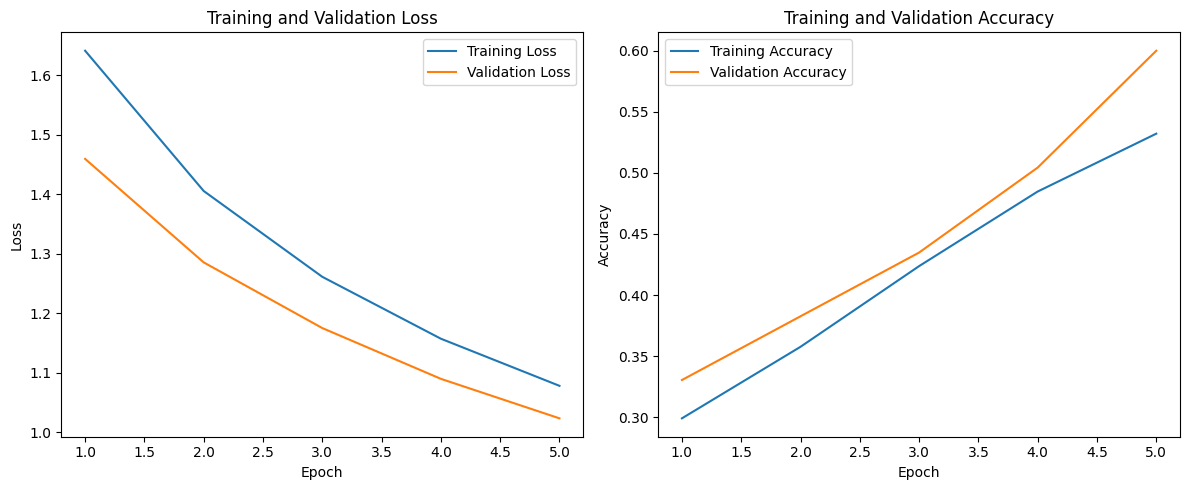


--- Final Evaluation Metrics ---
Accuracy: 0.4504
Precision: 0.4598
Recall: 0.4504
F1-Score: 0.4529

Classification Report:
               precision    recall  f1-score   support

       angry       0.49      0.47      0.48       160
       happy       0.38      0.44      0.40       135
     relaxed       0.41      0.43      0.42       145
         sad       0.56      0.45      0.50       135

    accuracy                           0.45       575
   macro avg       0.46      0.45      0.45       575
weighted avg       0.46      0.45      0.45       575



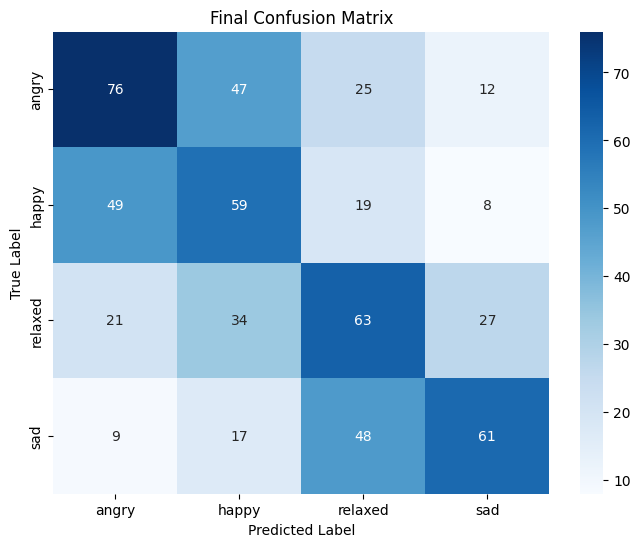

In [31]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), eval_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
cm = confusion_matrix(all_true_labels, all_predicted_labels)

print("\n--- Final Evaluation Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



class_names = evalDataset.dataset.classes
report = classification_report(all_true_labels, all_predicted_labels, target_names=class_names, zero_division=0)
print("\nClassification Report:\n", report)


# Plot Confusion Matrix
class_names = evalDataset.dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Confusion Matrix')
plt.show()

### Sampling 4 Images

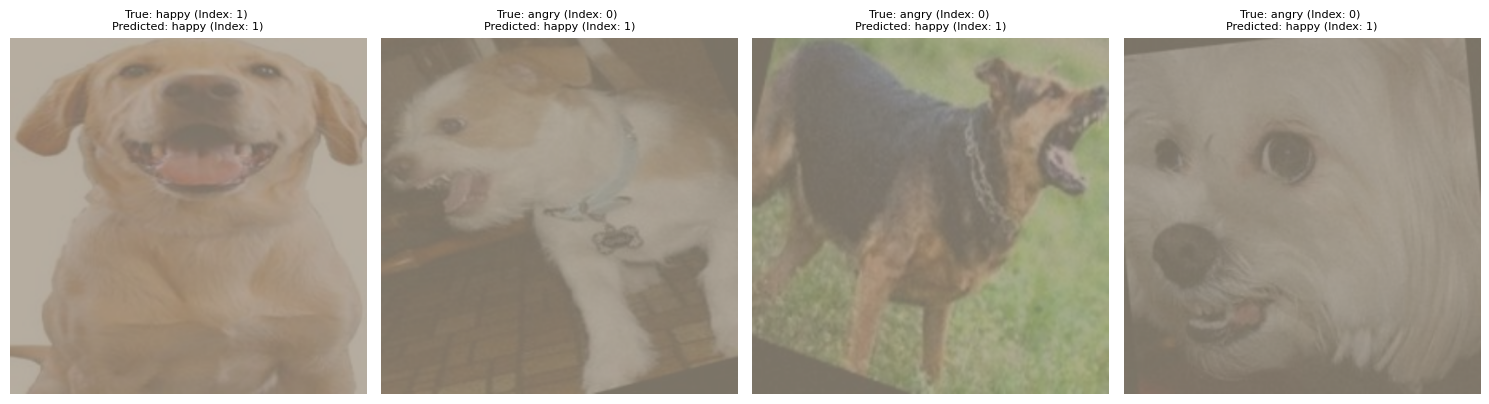

In [32]:
import random

# Assuming your model is trained and in evaluation mode (model.eval())
# Assuming you have your eval_dataloader and eval_dataset

model.eval()

def visualize_random_eval_samples(dataloader, dataset, model, image_processor, device, num_samples=4):
    # Get random indices within the dataset
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Create subplots for visualization
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))  # Adjust figsize as needed

    for i, random_index in enumerate(random_indices):
        # Get the sample at that index
        sample = dataset[random_index]
        image_tensor = sample[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
        true_label_tensor = torch.tensor([sample[1]]).to(device)  # Create a batch label

        # Perform inference
        with torch.no_grad():
            inputs = image_processor(images=[transforms.ToPILImage()(image_tensor.cpu().squeeze(0))], return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs).logits
            probabilities = torch.softmax(outputs, dim=-1)
            _, predicted_label_tensor = torch.max(probabilities, dim=-1)

        first_image_tensor = image_tensor.squeeze(0)
        first_true_label = true_label_tensor.item()
        first_predicted_label = predicted_label_tensor.item()

        class_names = dataset.dataset.classes
        first_true_class_name = class_names[first_true_label]
        first_predicted_class_name = class_names[first_predicted_label]

        mean = torch.tensor(image_processor.image_mean).cpu()
        std = torch.tensor(image_processor.image_std).cpu()
        unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
        img_unnormalized = unnormalize(first_image_tensor.cpu())
        img_pil = transforms.ToPILImage()(img_unnormalized)

        # Display the image in the subplot
        axes[i].imshow(img_pil)
        axes[i].set_title(f"True: {first_true_class_name} (Index: {dataset.dataset.class_to_idx[first_true_class_name]}) \nPredicted: {first_predicted_class_name} (Index: {dataset.dataset.class_to_idx[first_predicted_class_name]})", fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



# Call the function
visualize_random_eval_samples(eval_dataloader, evalDataset, model, image_processor, device, num_samples=4)